In [24]:
using ITensors, ITensorMPS, Plots
using Plots.PlotMeasures

In [25]:
N = 3 #Number of lattice sites per dimension
d = 1 #Number of spatial dimensions
dx = 1 #Lattice spacing

n_0 = round(Int, ((N-1)/2)) #Index of thepoint at the center of the lattice.
dp = (2*pi)/(N*dx) #Discrete change in momentum
#= p_max = n_0*dp
p_i = range(1/2*dp, stop = dp*(N+1/2), length = (N+1))[1:end-1]

om_i = Float64[] #List of omega values for each lattice site (eq. 12)
for i in 1:N
    push!(om_i, (2/dx)*abs(sin(p_i[i]*dx/2)))
end =#

Delta = 0
om_i = [2*sqrt([sin(pi*(k + Delta)/N)^2 for k in 0:N-1][i]) for i in 1:N]

3-element Vector{Float64}:
 0.0
 1.7320508075688772
 1.7320508075688774

In [26]:
H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
for i in 1:N
    H += (om_i[i]*dp)/(2pi), "a", i, "a†", i
    H += (om_i[i]*dp)/(2pi)*(1/2)*(2pi/dp), "Id", i
end

sites = siteinds("Boson", N; dim=9) #Create ITensor "SFT" sites

3-element Vector{Index{Int64}}:
 (dim=9|id=305|"Boson,Site,n=1")
 (dim=9|id=381|"Boson,Site,n=2")
 (dim=9|id=570|"Boson,Site,n=3")

In [27]:
function MakeState(excitation_dict)
    for i in keys(excitation_dict)
        if i > N
            error("excitation_dict contains an index that is greater than the number of sites in the lattice.")
        end
    end

    state = []
    for i in 1:N
        if haskey(excitation_dict, i)
            push!(state, excitation_dict[i])
        else
            push!(state, "0")
        end
    end

    return state
end

MakeState (generic function with 1 method)

In [28]:
gs_Dict = Dict() #Dictionary containing excitations (or lack thereof) in the ground state
psi_gs = MPS(sites, MakeState(gs_Dict)) #Ground State

MPS
[1] ((dim=9|id=305|"Boson,Site,n=1"), (dim=1|id=773|"Link,l=1"))
[2] ((dim=1|id=773|"Link,l=1"), (dim=9|id=381|"Boson,Site,n=2"), (dim=1|id=999|"Link,l=2"))
[3] ((dim=1|id=999|"Link,l=2"), (dim=9|id=570|"Boson,Site,n=3"))


In [29]:
function phi_n(m::Real) #Field value in the lightlike direction, i.e. phi_x_{n_0+m}
    phi_lightlike = OpSum()
    for s in 0:N-1
        i = s+1
        phi_lightlike += (1/sqrt(N)*exp(im*m*om_i[i]))*exp(-im*2pi*m*(s+Delta)/N)*(1/sqrt(2*om_i[i])), "a", (i)
        phi_lightlike += -(1/sqrt(N)*exp(im*m*om_i[i]))*exp(-im*2pi*m*(s+Delta)/N)*(1/sqrt(2*om_i[i])), "a†", (i)
    end
    return phi_lightlike
end

function phi_nbar(m::Real) #Field value in the anti-lightlike direction, i.e. phi_x_{n_0-m}
    phi_antilightlike = OpSum()
    for s in 0:N-1
        i = s+1
        phi_antilightlike += (1/sqrt(N)*exp(im*m*om_i[i]))*exp(im*2pi*m*(s+Delta)/N)*(1/sqrt(2*om_i[i])), "a", (i)
        phi_antilightlike += -(1/sqrt(N)*exp(im*m*om_i[i]))*exp(im*2pi*m*(s+Delta)/N)*(1/sqrt(2*om_i[i])), "a†", (i)
    end
    return phi_antilightlike
end

phi_nbar (generic function with 1 method)

In [32]:
function Y_n(g::Real)
    Y_n_op = OpSum()
    for m in 0:n_0
        Y_n_op += im*g*dx*phi_n(m)
    end
    return Y_n_op
end

function Y_n_dag(g::Real)
    Y_n_dag_op = OpSum()
    for m in 0:n_0
        Y_n_dag_op += -im*g*dx*phi_n(m)
    end
    return Y_n_dag_op
end

function Y_nbar(g::Real)
    Y_nbar_op = OpSum()
    for m in 0:n_0
        Y_nbar_op += im*g*dx*phi_nbar(m)
    end
    return Y_nbar_op
end

function Y_nbar_dag(g::Real)
    Y_nbar_dag_op = OpSum()
    for m in 0:n_0
        Y_nbar_dag_op += -im*g*dx*phi_nbar(m)
    end
    return Y_nbar_dag_op
end

Y_nbar_dag (generic function with 1 method)

In [33]:
function YnbdYn(g::Real)
    return MPO(Y_nbar_dag(g)+Y_n(g), sites)
end

function YndYnb(g::Real)
    return MPO(Y_n_dag(g)+Y_nbar(g), sites)
end

function TimeOrderedOp()
    OS = OpSum()
    for m in n_0:-1:0
        if m == n_0
            OS += -im*H*n_0
        else
            OS += im*H
        end
    end
    return MPO(OS, sites)
end

TimeOrderedOp (generic function with 1 method)

In [34]:
t_range = range(0, stop=5, length=101)
#= ITensors.set_warn_order(N)
ITensors.set_warn_order(N) =#

0.0:0.05:5.0

### Calculating S(t)

In [35]:
g = 1
S_t = []
for t in t_range
    psi_0 = tdvp(YnbdYn(g), 1, psi_gs; nsteps=1, maxdim=500, cutoff=1e-15) #tdvp calculates exp(op*t)|psi>. By setting t=1, tdvp reduces to exp(op)|psi>
    #psi_0 = tdvp(TimeOrderedOp(), dx, psi_0; nsteps=1, maxdim=500, cutoff=1e-15)

    psi_t = tdvp(MPO(-im*H, sites), t, psi_0; nsteps=1, maxdim=500, cutoff=1e-15) #Time evolve the psi_0 state
    psi_final = tdvp(YndYnb(g), 1, psi_t; nsteps=1, maxdim=500, cutoff=1e-15) #Apply the Wilson line operator in reverse
    #psi_final = tdvp(TimeOrderedOp(), dx, psi_final; nsteps=1, maxdim=500, cutoff=1e-15)
    Psi = tdvp(MPO(im*H, sites), t, psi_final; nsteps=1, maxdim=500, cutoff=1e-15) #Time evolve back

    exp_val_gs = (inner(psi_gs, Psi))
    push!(S_t, exp_val_gs)
end

### Calculating S(E)

In [36]:
function S(E::Real)
    dt = (2/dx)/(length(t_range)-1)
    FTSoftFunc = 0
    for t in 1:(length(t_range)-1)
        f1 = exp(im*E*t_range[t])*S_t[t]
        f2 = exp(im*E*t_range[t+1])*S_t[t+1]
        FTSoftFunc += (dt/2)*(f1+f2)
    end
    return FTSoftFunc
end

S (generic function with 1 method)

In [37]:
E_range = 0:0.05:10
S_list = [S(E) for E in E_range]

201-element Vector{ComplexF64}:
    2.5419926359192857 + 1.690543039443395im
    2.2292186044877313 + 2.034611871755393im
    1.8596856826758092 + 2.314262839100283im
    1.4473658885472476 + 2.5195956674597517im
    1.0079713885814658 + 2.643824011990704im
     0.558250462591002 + 2.6835736210835845im
     0.115235724123767 + 2.6390202159662755im
  -0.30451883111009603 + 2.5138605610147136im
   -0.6856748585085171 + 2.3151185361505138im
   -1.0147850649786019 + 2.052796256938838im
   -1.2808744573235837 + 1.739387992589826im
   -1.4758997650033563 + 1.3892814078192532im
   -1.5950656030237627 + 1.0180761519820316im
                       ⋮
  -0.07203165427484315 + 0.1361834956429544im
  -0.09302652263806349 + 0.11463194782123426im
  -0.10801054054880238 + 0.08870177736890794im
  -0.11612638125213742 + 0.060029292734158496im
   -0.1169497652005448 + 0.030401832805877847im
  -0.11051081009296931 + 0.0016459732101031938im
  -0.09728717301740662 - 0.02448545365583466im
  -0.07816971451481

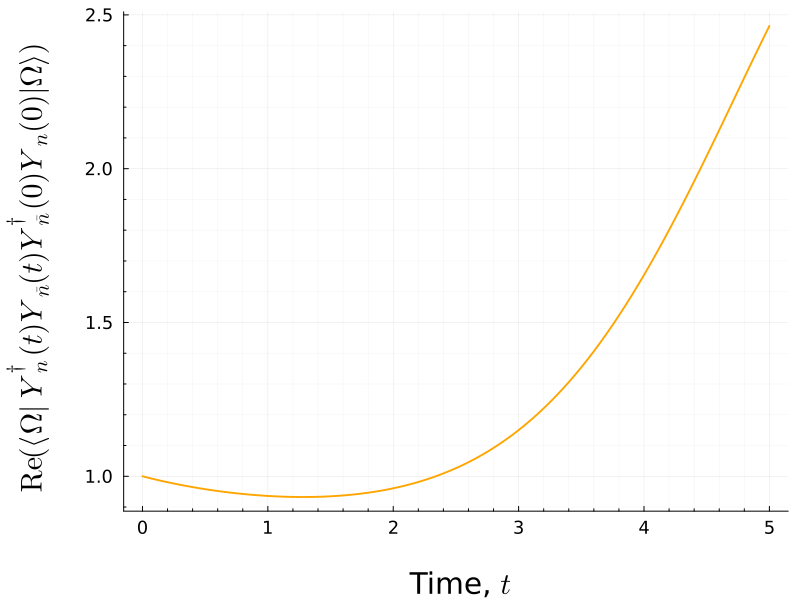

In [38]:
gr()
default(size=(800, 600))
plot(t_range, real(S_t), linewidth=1.9, label="", linestyle=:solid, color="orange")

# Axis labels with larger font via `guidefont`
xlabel!("\n Time, \$t\$", guidefont=font(20))
ylabel!("\$\\mathrm{Re}(\\langle \\Omega |Y_{n}^\\dag (t) Y_{\\bar{n}} (t) Y_{\\bar{n}}^\\dag (0) Y_{n} (0)| \\Omega\\rangle)\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Add legend
#plot!(legend=:topright, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("S(t), N=51, g=2e-1")

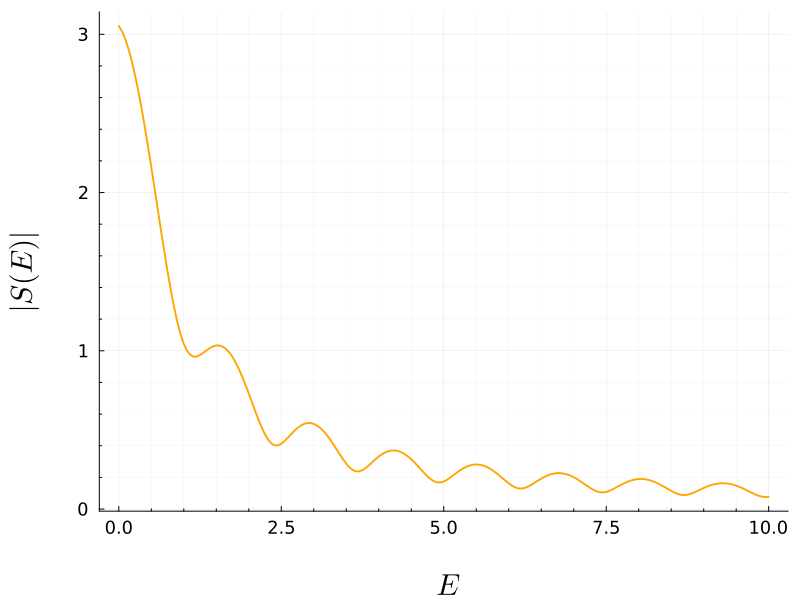

In [14]:
gr()
default(size=(800, 600))
plot(E_range, [abs(S_list[i]) for i in 1:length(E_range)], linewidth=1.9, label="", linestyle=:solid, color="orange")

# Axis labels with larger font via `guidefont`
xlabel!("\n \$E\$", guidefont=font(20))
ylabel!("\$|S(E)|\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Add legend
#plot!(legend=:topright, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("S(E), N=51, g=2e-1")

### Reproducing the results of 2102.05044 with N=101

In [15]:
N = 101 #Number of lattice sites per dimension

n_0 = round(Int, ((N-1)/2)) #Index of thepoint at the center of the lattice.
dp = (2*pi)/(N*dx) #Discrete change in momentum
#= p_i = range(1/2*dp, stop = dp*(N+1/2), length = (N+1))[1:end-1]

om_i = Float64[] #List of omega values for each lattice site (eq. 12)
for i in 1:N
    push!(om_i, (2/dx)*abs(sin(p_i[i]*dx/2)))
end =#

Delta = 1/2
om_i = [2*sqrt([sin(pi*(k + Delta)/N)^2 for k in 0:N-1][i]) for i in 1:N]

H = OpSum() #Evaluate the sum of the pi^2 and phi operators that make up the Hamiltonian
for i in 1:N
    H += (om_i[i]*dp)/(2pi), "a", i, "a†", i
    H += (om_i[i]*dp)/(2pi)*(1/2)*(2pi/dp), "Id", i
end

sites = siteinds("Boson", N; dim=9) #Create ITensor "SFT" sites

psi00000 = MPS(sites, MakeState(Dict()))
psi10000 = MPS(sites, MakeState(Dict(1=>"1")))
psi10001 = MPS(sites, MakeState(Dict(1=>"1", N=>"1")))

MPS
[1] ((dim=9|id=628|"Boson,Site,n=1"), (dim=1|id=827|"Link,l=1"))
[2] ((dim=1|id=827|"Link,l=1"), (dim=9|id=649|"Boson,Site,n=2"), (dim=1|id=260|"Link,l=2"))
[3] ((dim=1|id=260|"Link,l=2"), (dim=9|id=384|"Boson,Site,n=3"), (dim=1|id=724|"Link,l=3"))
[4] ((dim=1|id=724|"Link,l=3"), (dim=9|id=464|"Boson,Site,n=4"), (dim=1|id=293|"Link,l=4"))
[5] ((dim=1|id=293|"Link,l=4"), (dim=9|id=227|"Boson,Site,n=5"), (dim=1|id=466|"Link,l=5"))
[6] ((dim=1|id=466|"Link,l=5"), (dim=9|id=470|"Boson,Site,n=6"), (dim=1|id=119|"Link,l=6"))
[7] ((dim=1|id=119|"Link,l=6"), (dim=9|id=859|"Boson,Site,n=7"), (dim=1|id=116|"Link,l=7"))
[8] ((dim=1|id=116|"Link,l=7"), (dim=9|id=133|"Boson,Site,n=8"), (dim=1|id=563|"Link,l=8"))
[9] ((dim=1|id=563|"Link,l=8"), (dim=9|id=896|"Boson,Site,n=9"), (dim=1|id=323|"Link,l=9"))
[10] ((dim=1|id=323|"Link,l=9"), (dim=9|id=237|"Boson,Site,n=10"), (dim=1|id=639|"Link,l=10"))
[11] ((dim=1|id=639|"Link,l=10"), (dim=9|id=323|"Boson,Site,n=11"), (dim=1|id=874|"Link,l=11"))
[12]

In [16]:
g_list = range(0, stop=0.06, length=31)
ITensors.set_warn_order(N)
ITensors.set_warn_order(N)

101

In [17]:
exp_val_list_00000 = []
exp_val_list_10000 = []
exp_val_list_10001 = []
for g in g_list
    Psi = tdvp(YnbdYn(g), 1, psi00000; nsteps=1, maxdim=500, cutoff=1e-15) #Note that the operators are completely out of order. Itensor is able to handle the operators regardless of how they are ordered.
    #Psi = tdvp(TimeOrderedOp(), dx, Psi; nsteps=1, maxdim=500, cutoff=1e-15)
    normalize!(Psi)

    exp_val_00000 = abs2(inner(psi00000, Psi))
    exp_val_10000 = abs2(inner(psi10000, Psi))
    exp_val_10001 = abs2(inner(psi10001, Psi))
    push!(exp_val_list_00000, exp_val_00000)
    push!(exp_val_list_10000, exp_val_10000)
    push!(exp_val_list_10001, exp_val_10001)
end

In [18]:
analytic_00000 = [1.000000000000000000e+00, 9.908232690580748292e-01, 9.637952664909003042e-01, 9.203770382643921000e-01,
 8.628576543282623357e-01, 7.941543723344067773e-01, 7.175680628197959043e-01, 6.365223615483031061e-01,
 5.543149913457101619e-01, 4.739057492787654979e-01, 3.977587345319131829e-01, 3.277478621707901052e-01,
 2.651260517527713745e-01, 2.105510132192215111e-01, 1.641552063982073262e-01, 1.256447602092179150e-01,
 9.441184759630143197e-02, 6.964677416800643672e-02, 5.043916749037805070e-02, 3.586139736730002692e-02,
 2.503104039189176996e-02, 1.715232465794841801e-02, 1.153876876487479157e-02, 7.620585614950455174e-03,
 4.940940425370784171e-03, 3.145019067826486815e-03, 1.965302210993053692e-03, 1.205668174349711769e-03,
 7.261371327676177179e-04, 4.293405313279478452e-04, 2.492169216752571320e-04]

analytic_10000 = [0.000000000000000000e+00, 2.260610607271971127e-03, 8.795779714536123076e-03, 1.889895750663164731e-02,
 3.149841513584319963e-02, 4.529752817617135885e-02, 5.893796895637732486e-02, 7.116055215259625699e-02,
 8.094055201733692251e-02, 8.758032654955788532e-02, 9.075055486663341497e-02, 9.048046038224337451e-02,
 8.710527581914363771e-02, 8.118459044467558894e-02, 7.340747682520110118e-02, 6.449951719250751614e-02,
 5.514371561822246220e-02, 4.592280556378730560e-02, 3.728571570543796898e-02, 2.953683615438552554e-02,
 2.284380562630774006e-02, 1.725802690344005116e-02, 1.274190596606940631e-02, 9.197580179584077115e-03,
 6.493243130391545756e-03, 4.484694500286589072e-03, 3.031137255717954778e-03, 2.005325559409066455e-03,
 1.298865772584815960e-03, 8.238107390298614113e-04, 5.117402778274473575e-04]

analytic_10001 = [0.000000000000000000e+00, 5.157691060857568287e-06, 8.027196592106829989e-05, 3.880698670090713628e-04,
 1.149842214521814687e-03, 2.583711845392962919e-03, 4.840912471846199432e-03, 7.955453709976306395e-03,
 1.181886303483585011e-02, 1.618531450652484563e-02, 2.070517249179603531e-02, 2.497869446579800701e-02,
 2.861781792233743585e-02, 3.130328192155173300e-02, 3.282660216557857502e-02, 3.311071397756007451e-02,
 3.220813329684790727e-02, 3.027999639670549484e-02, 2.756240169768733525e-02, 2.432768252378595189e-02,
 2.084769339677796859e-02, 1.736438054545794141e-02, 1.407049321781910813e-02, 1.110091604953737654e-02,
 8.533235117323368160e-03, 6.395027924202789128e-03, 4.675002659442777445e-03, 3.335354357668263506e-03,
 2.323324643600392907e-03, 1.580712940475981123e-03, 1.050803894817992383e-03]

31-element Vector{Float64}:
 0.0
 5.157691060857568e-6
 8.02719659210683e-5
 0.00038806986700907136
 0.0011498422145218147
 0.002583711845392963
 0.004840912471846199
 0.007955453709976306
 0.01181886303483585
 0.016185314506524846
 0.020705172491796035
 0.024978694465798007
 0.028617817922337436
 ⋮
 0.024327682523785952
 0.02084769339677797
 0.01736438054545794
 0.014070493217819108
 0.011100916049537377
 0.008533235117323368
 0.006395027924202789
 0.0046750026594427774
 0.0033353543576682635
 0.002323324643600393
 0.0015807129404759811
 0.0010508038948179924

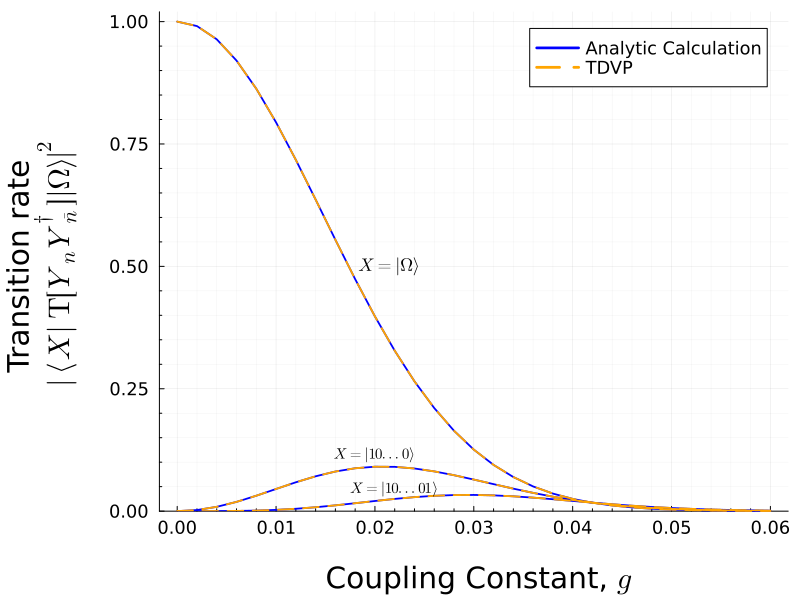

In [19]:
gr()
default(size=(800, 600))
plot(g_list, analytic_00000, linewidth=1.8, label="Analytic Calculation", color="blue")
plot!(g_list, analytic_10000, linewidth=1.8, label="", color="blue")
plot!(g_list, analytic_10001, linewidth=1.8, label="", color="blue")

plot!(g_list, exp_val_list_00000, linewidth=1.9, label="TDVP", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_10000, linewidth=1.9, label="", linestyle=:dash, color="orange")
plot!(g_list, exp_val_list_10001, linewidth=1.9, label="", linestyle=:dash, color="orange")

# Add text annotations
annotate!(0.0215, 0.5, text("\$X = |\\Omega\\rangle\$", 12))
annotate!(0.020, 0.115, text("\$X = |10...0\\rangle\$", 10))
annotate!(0.022, 0.045, text("\$X = |10...01\\rangle\$", 10))

# Axis labels with larger font via `guidefont`
xlabel!("\n Coupling Constant, \$g\$", guidefont=font(20))
ylabel!("Transition rate \n \$|\\langle X | \\mathrm{T}[Y_{n}Y_{\\bar{n}}^\\dag] | \\Omega\\rangle|^2\$ \n", guidefont=font(20))

plot!(tickfontsize=12)

# Set margins
plot!(left_margin = 18px)

# Set y-limits
ylims!(0, 1.02)

# Add legend
plot!(legend=:topright, legendfontsize=12, frame=false)

# Enable minor ticks
plot!(minorgrid=true)

#savefig("Transition Rates, N=101 (TDVP)")